# Import Library

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns

import itertools

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import scikitplot as skplt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import pydotplus
from IPython.display import Image

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from collections import Counter

# Import Data

In [2]:
data = pd.read_csv('data.csv')

# Exploratory data analysis

# Data Pre-processing

### Drop data

In [3]:
data = data.drop(['id','Driving_License','Region_Code',"Policy_Sales_Channel"], axis=1)

### Encode categorical variables

In [4]:
data = pd.get_dummies(data, columns=["Gender", "Vehicle_Age","Vehicle_Damage"], prefix=["Gender", "Vehicle_Age","Vehicle_Damage"], drop_first=True)
data.head()

,Age,Previously_Insured,Annual_Premium,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,0,40454.0,217,1,1,0,1,1
1,76,0,33536.0,183,0,1,0,0,0
2,47,0,38294.0,27,1,1,0,1,1
3,21,1,28619.0,203,0,1,1,0,0
4,29,1,27496.0,39,0,0,1,0,0


# Data Split

The original data set was already split to 'train' and 'test', but as the 'test' data set was missing value, we decided to split the 'train' data again into 'train_new' and 'test_new'

In [5]:
X, y = data.loc[:, data.columns != 'Response'], data['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)

Visualization of the split data

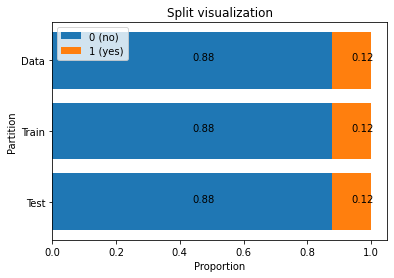

In [6]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

# Data Balancing

Data rebalancing with SMOTE

In [7]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [8]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

Original label Counter({0: 234078, 1: 32698})
SMOTE label Counter({0: 234078, 1: 234078})


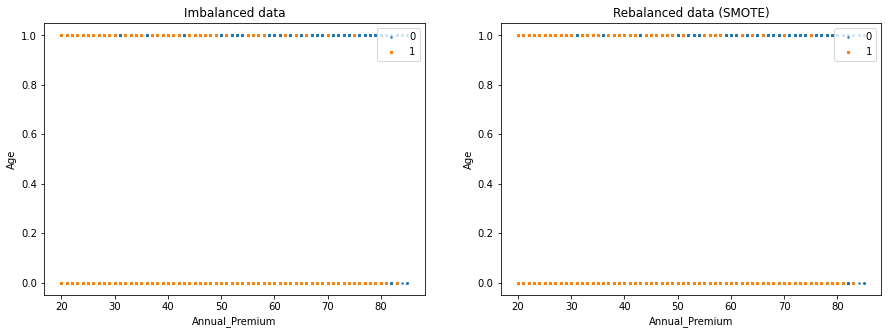

In [9]:
print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_sm))

fig = plt.figure(figsize=(15, 5))

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='Annual_Premium', ylabel='Age')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_sm), y_sm, title='Rebalanced data (SMOTE)', xlabel='Annual_Premium', ylabel='Age')

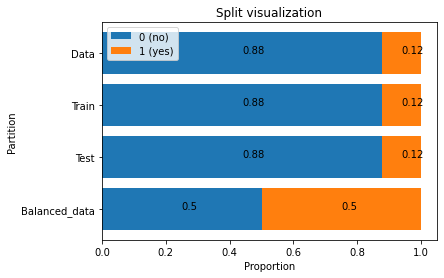

In [10]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['Balanced_data','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Balanced_data','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Balanced_data', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

# Model Building

## 1. Decision Tree

#### a) Imbalanced data

In [11]:
tree_imb = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_train, y_train)

In [12]:
y_pred_tree_imb = tree_imb.predict(X_test)
y_predProba_tree_imb = tree_imb.predict_proba(X_test)
print ("DT accuracy of imbalanced data is: ", (accuracy_score(y_test, y_pred_tree_imb)*100).round(2))

DT accuracy of imbalanced data is:  87.74


##### Tree visualization

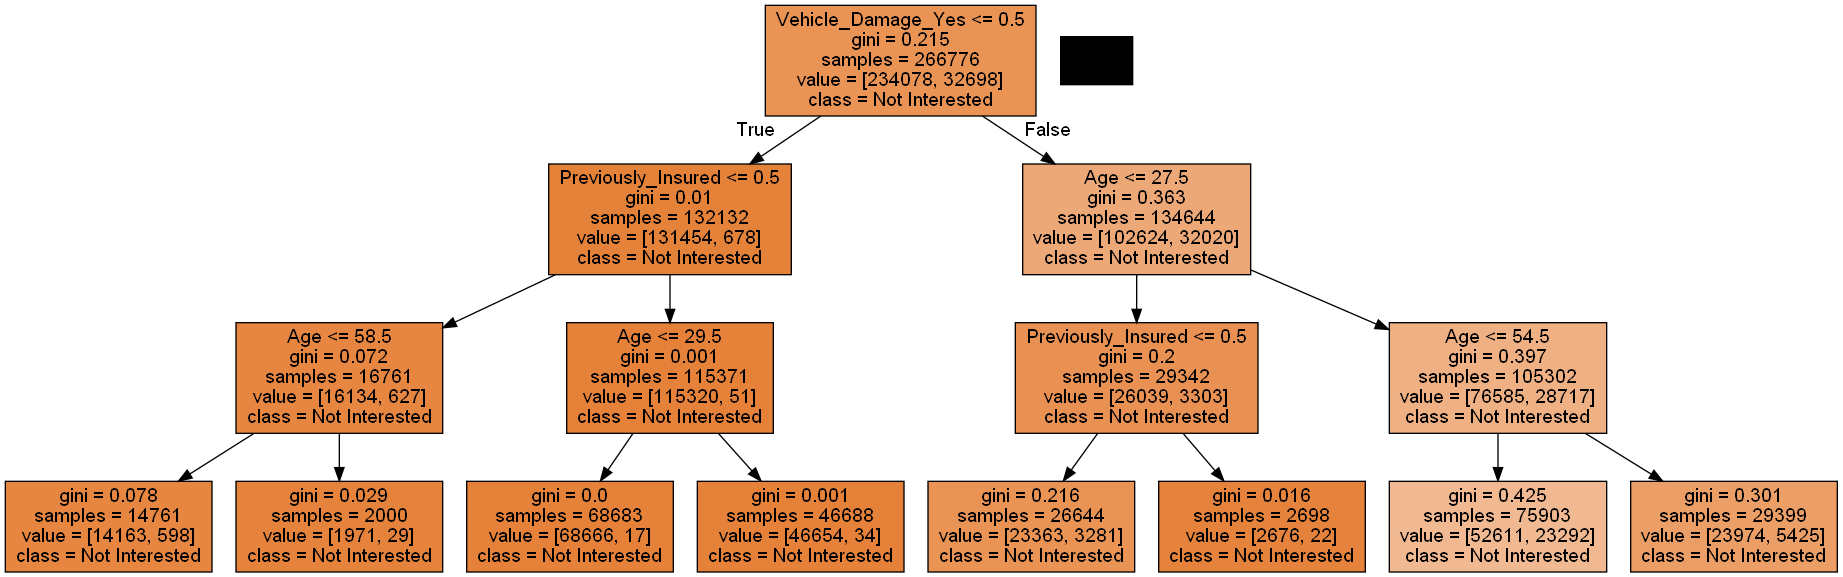

In [13]:
'''
The graphviz library is used to visualize the tree. 
'''

#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(tree_imb, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['Not Interested', 'Interested'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [14]:
importances = tree_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

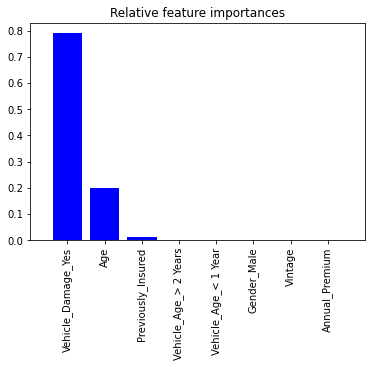

In [15]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
print(classification_report(y_test, y_pred_tree_imb))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100321
           1       0.00      0.00      0.00     14012

    accuracy                           0.88    114333
   macro avg       0.44      0.50      0.47    114333
weighted avg       0.77      0.88      0.82    114333



C:\Users\qlam1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qlam1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qlam1\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### b) Balanced data

In [17]:
tree_bal = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_sm, y_sm)

y_pred_tree_bal = tree_bal.predict(X_test)
y_predProba_tree_bal = tree_bal.predict_proba(X_test)
print ("DT accuracy of balanced data is: ", (accuracy_score(y_test, y_pred_tree_bal)*100).round(2))

DT accuracy of balanced data is:  74.11


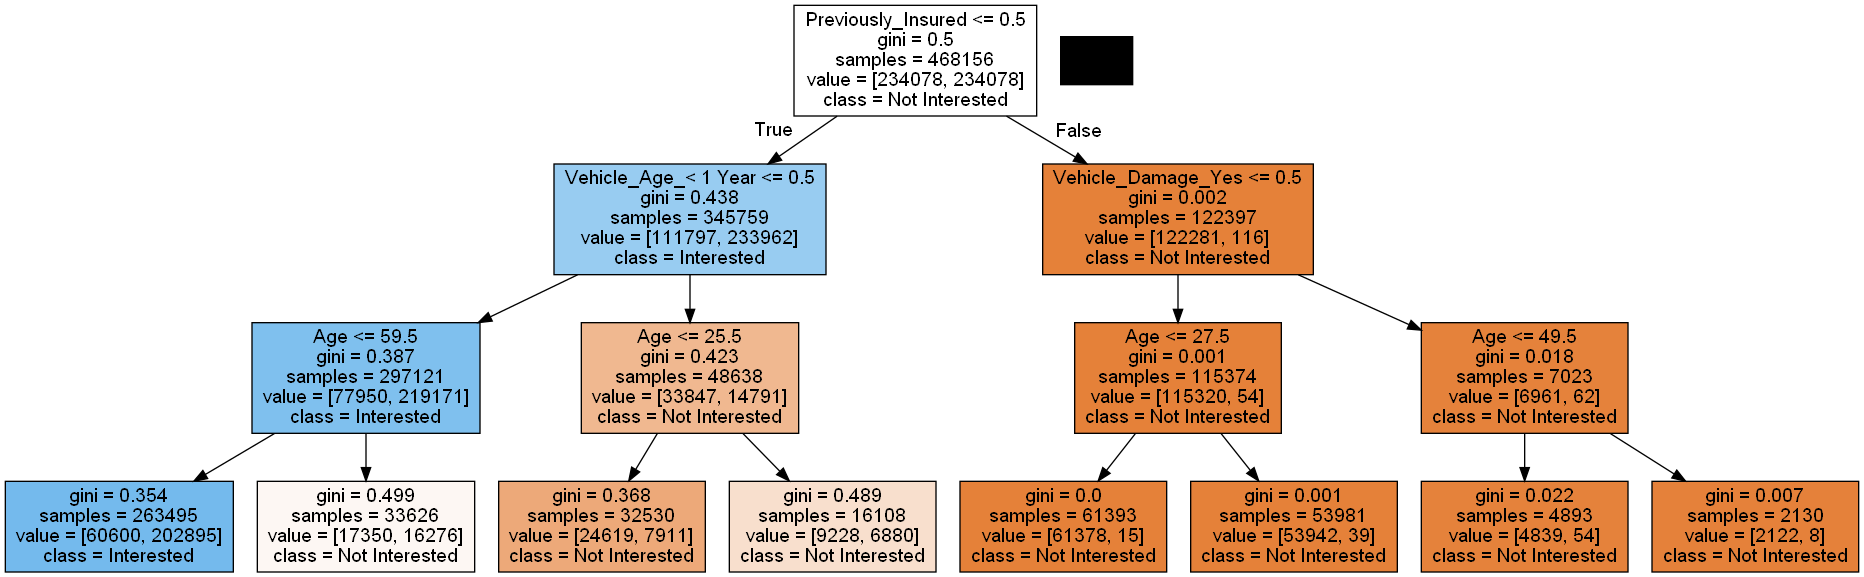

In [18]:
'''
The graphviz library is used to visualize the tree. 
'''

#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(tree_bal, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['Not Interested', 'Interested'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [19]:
importances = tree_bal.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

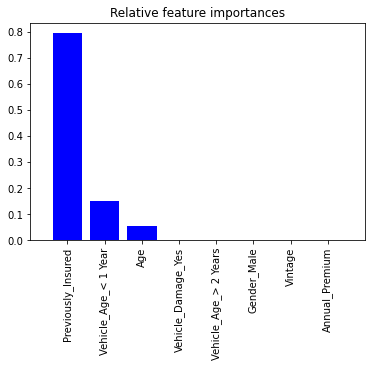

In [20]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [21]:
print(classification_report(y_test, y_pred_tree_bal))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83    100321
           1       0.29      0.75      0.41     14012

    accuracy                           0.74    114333
   macro avg       0.62      0.74      0.62    114333
weighted avg       0.87      0.74      0.78    114333



#### Confusion Matrix

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

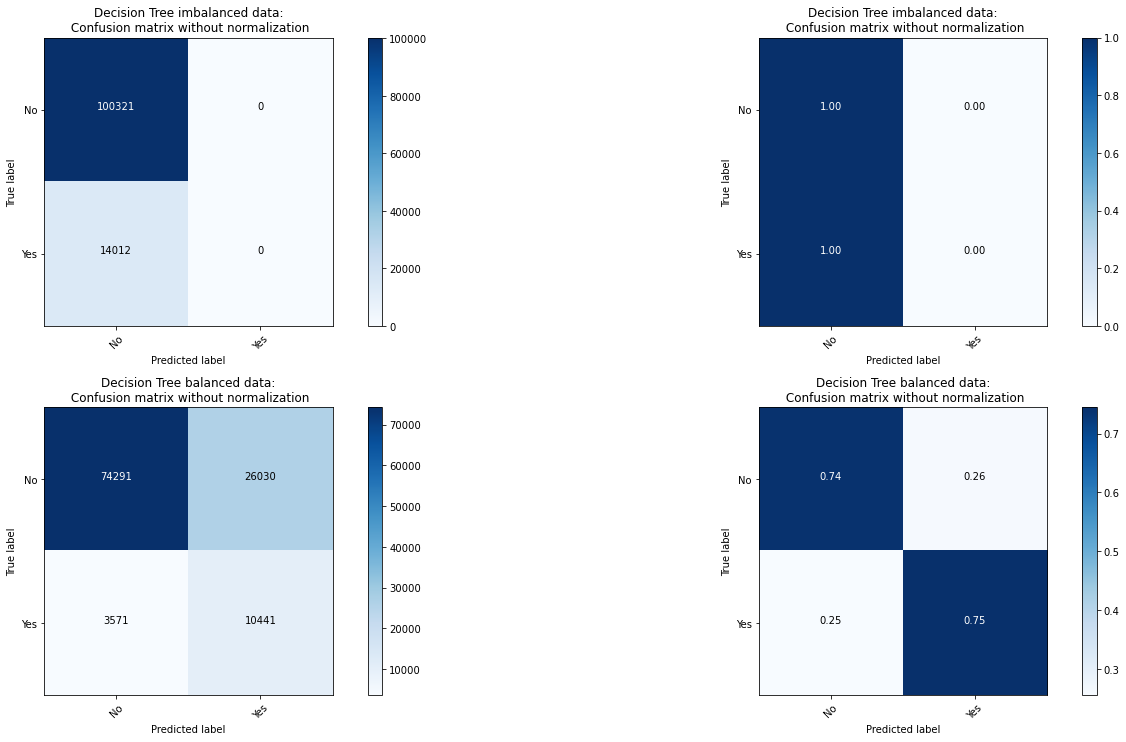

In [23]:

class_names = ['No','Yes']
cnf_matrix_tree_imb = confusion_matrix(y_test, y_pred_tree_imb)
cnf_matrix_tree_bal = confusion_matrix(y_test, y_pred_tree_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Decision Tree (imbalanced) confusion matrix
plt.subplot(321)
plot_confusion_matrix(cnf_matrix_tree_imb, classes=class_names,
                      title='Decision Tree imbalanced data:\n Confusion matrix without normalization')

#Plot Decision Tree (imbalanced) normalized confusion matrix
plt.subplot(322)
plot_confusion_matrix(cnf_matrix_tree_imb, classes=class_names,normalize=True,
                      title='Decision Tree imbalanced data:\n Confusion matrix without normalization')

#Plot Decision Tree (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_tree_bal, classes=class_names,
                      title='Decision Tree balanced data:\n Confusion matrix without normalization')

#Plot Decision Tree (balanced) normalized confusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_tree_bal, classes=class_names,normalize=True,
                      title='Decision Tree balanced data:\n Confusion matrix without normalization')

plt.show()

#### ROC & AUC

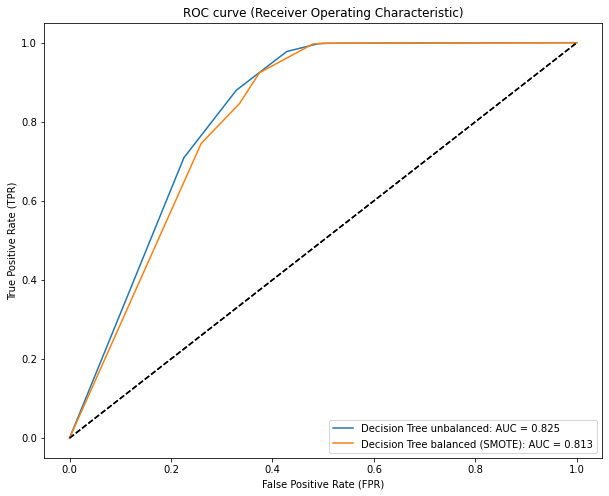

In [24]:
plt.figure(figsize=(10,8))

for test, pred, name in zip([y_test, y_test], [y_predProba_tree_imb[:,1], y_predProba_tree_bal[:,1]], ['Decision Tree unbalanced','Decision Tree balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

## 2. Logistics Regression

#### a) Imbalanced data

In [25]:
lr_ibal = LogisticRegression().fit(X_train, y_train)

In [26]:
y_pred_lr_ibal = lr_ibal.predict(X_test)
y_predProba_lr_ibal = lr_ibal.predict_proba(X_test)
print ("LR accuracy of imbalanced data is: ", (accuracy_score(y_test, y_pred_lr_ibal)*100).round(2))

LR accuracy of imbalanced data is:  87.55


In [44]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.279078
         Iterations 11
                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.250      
Dependent Variable:   Response          AIC:               148918.7030
Date:                 2022-02-10 19:39  BIC:               149002.6563
No. Observations:     266776            Log-Likelihood:    -74451.    
Df Model:             7                 LL-Null:           -99243.    
Df Residuals:         266768            LLR p-value:       0.0000     
Converged:            1.0000            Scale:             1.0000     
No. Iterations:       11.0000                                         
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
Age                   -0.0399   0.0005 -81.0487 0.0000 -0.0409 -0.0390
Pr

#### b) Balanced data

In [27]:
lr_bal = LogisticRegression().fit(X_sm, y_sm)

In [28]:
y_pred_lr_bal = lr_bal.predict(X_test)
y_predProba_lr_bal = lr_bal.predict_proba(X_test)
print ("LR accuracy of imbalanced data is:", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

LR accuracy of imbalanced data is: 70.96


In [45]:
import statsmodels.api as sm
logit_model=sm.Logit(y_sm,X_sm)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.402126
         Iterations 11
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.420      
Dependent Variable:    Response          AIC:               376531.6720
Date:                  2022-02-10 19:40  BIC:               376620.1245
No. Observations:      468156            Log-Likelihood:    -1.8826e+05
Df Model:              7                 LL-Null:           -3.2450e+05
Df Residuals:          468148            LLR p-value:       0.0000     
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        11.0000                                         
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Age                   -0.0204   0.0003  -67.3533 0.0000 -0.020

### Model evaluation



#### Confusion matrix

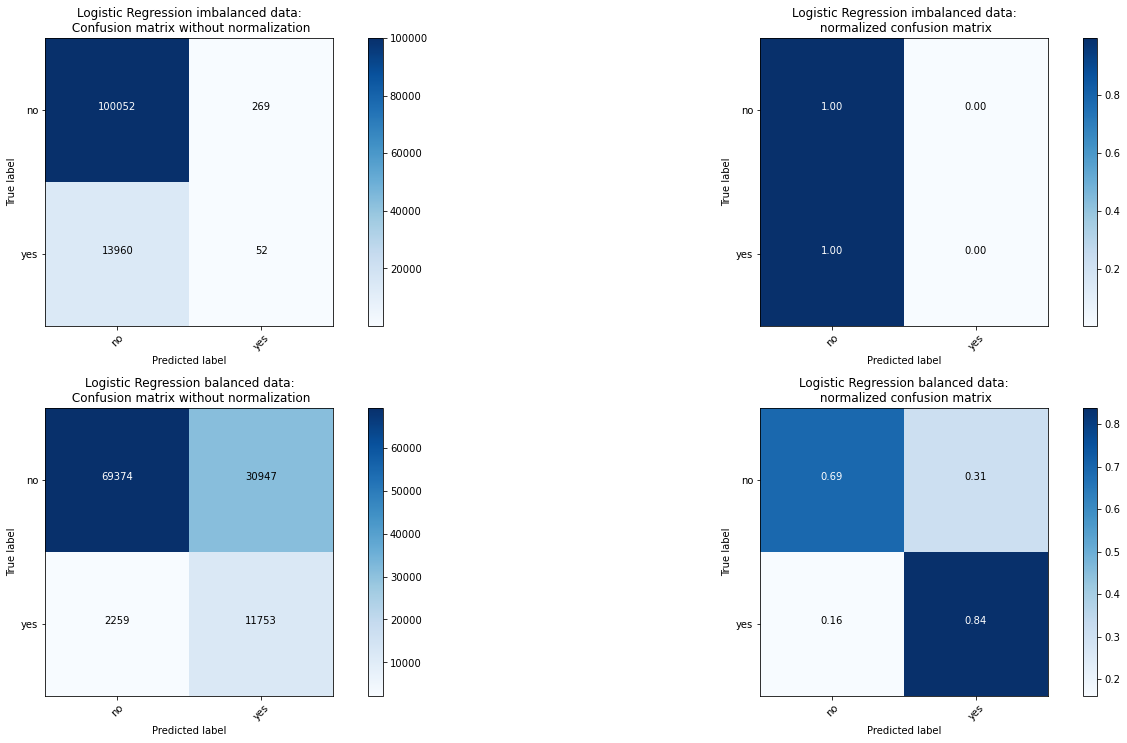

In [29]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_lr_ibal = confusion_matrix(y_test, y_pred_lr_ibal)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_lr_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_lr_ibal, classes=class_names,
                      title='Logistic Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (imbalanced) normalized confusion matrix
plt.subplot(322) 
plot_confusion_matrix(cnf_matrix_lr_ibal, classes=class_names, normalize=True,
                      title='Logistic Regression imbalanced data:\n normalized confusion matrix')


#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')

#### ROC and AUC

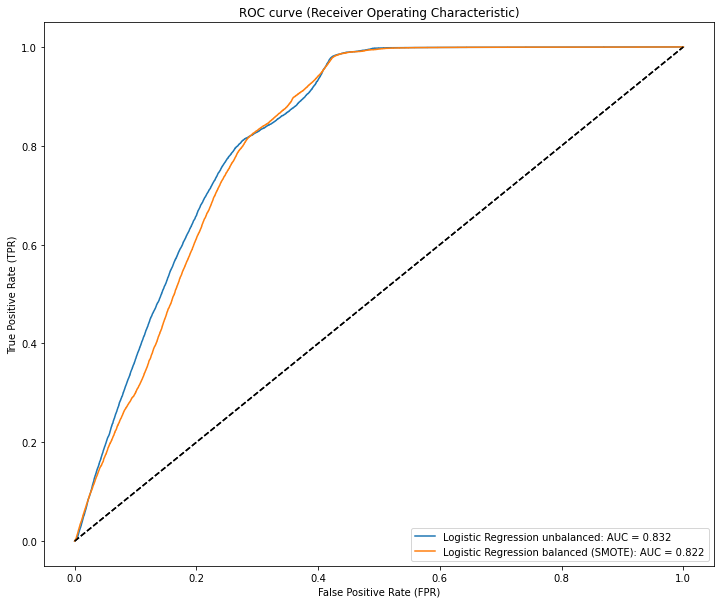

In [30]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test], [y_predProba_lr_ibal[:,1], y_predProba_lr_bal[:,1]], ['Logistic Regression unbalanced','Logistic Regression balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

### 3. Random forest

#### a) Imbalanced data

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_imb = RandomForestClassifier(max_depth = 3, min_samples_leaf=10,random_state=42, n_estimators=100, n_jobs=-1).fit(X_train,y_train)

In [32]:
y_pred_rf_imb = rf_imb.predict(X_test)
y_predProba_rf_imb = rf_imb.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf_imb)*100).round(2))

Accuracy is:  87.74


In [33]:
importances = rf_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

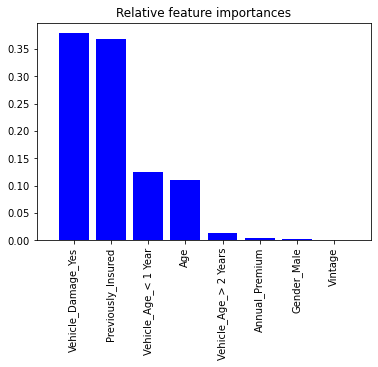

In [34]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

#### b) balanced data

In [35]:
rf_bal = RandomForestClassifier(max_depth = 3, min_samples_leaf=10,random_state=42, n_estimators=100, n_jobs=-1).fit(X_sm,y_sm)

In [36]:
y_pred_rf_bal = rf_bal.predict(X_test)
y_predProba_rf_bal = rf_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf_bal)*100).round(2))

Accuracy is:  70.5


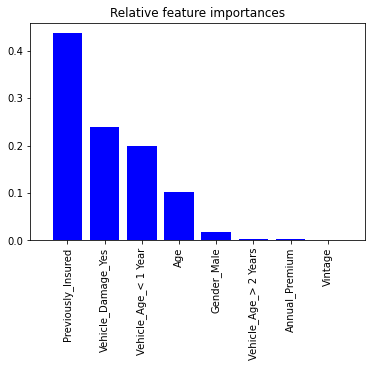

In [37]:
importances = rf_bal.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


#### Confusion matrix

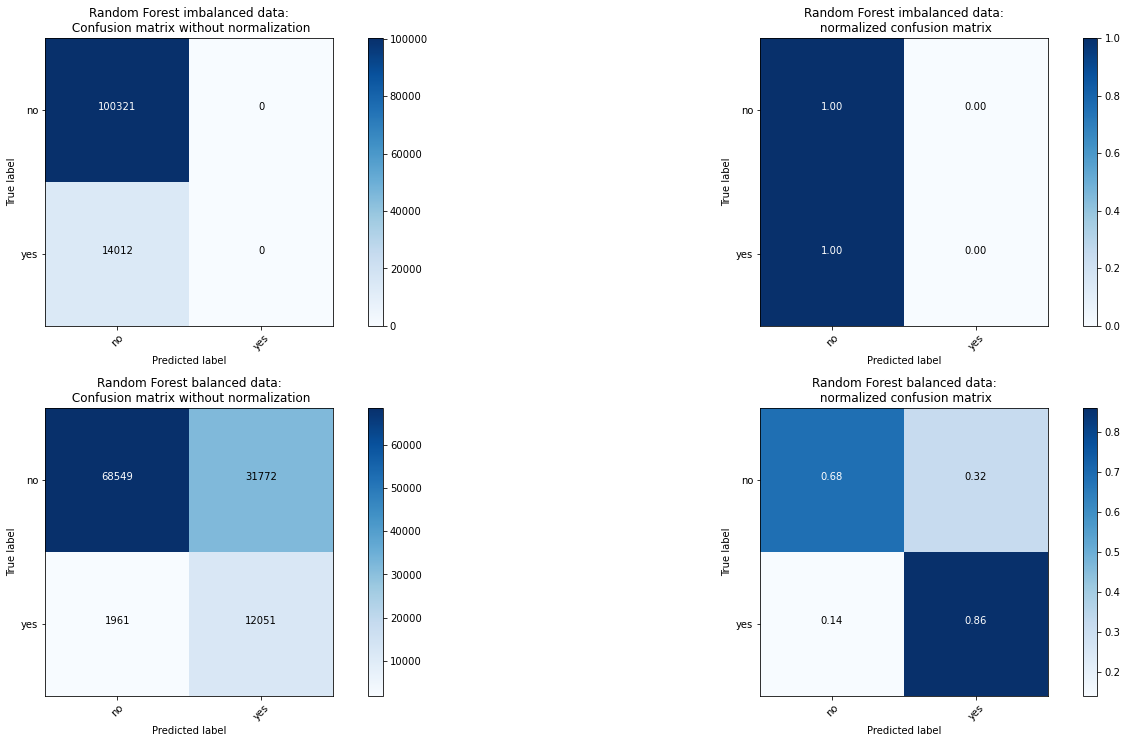

In [38]:
class_names = ['no', 'yes']
cnf_matrix_rf_imb = confusion_matrix(y_test, y_pred_rf_imb)
cnf_matrix_rf_bal = confusion_matrix(y_test, y_pred_rf_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot K-Nearest Neighbors (imbalanced) confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_rf_imb, classes=class_names,
                      title='Random Forest imbalanced data:\n Confusion matrix without normalization')

#Plot K-Nearest Neighbors (imbalanced) normalized confusion matrix
plt.subplot(322) 
plot_confusion_matrix(cnf_matrix_rf_imb, classes=class_names, normalize=True,
                      title='Random Forest imbalanced data:\n normalized confusion matrix')

#Plot K-Nearest Neighbors (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_rf_bal, classes=class_names,
                      title='Random Forest balanced data:\n Confusion matrix without normalization')

#Plot K-Nearest Neighbors (balanced) normalized onfusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_rf_bal, classes=class_names, normalize=True,
                      title='Random Forest balanced data:\n normalized confusion matrix')

#### ROC and AUC

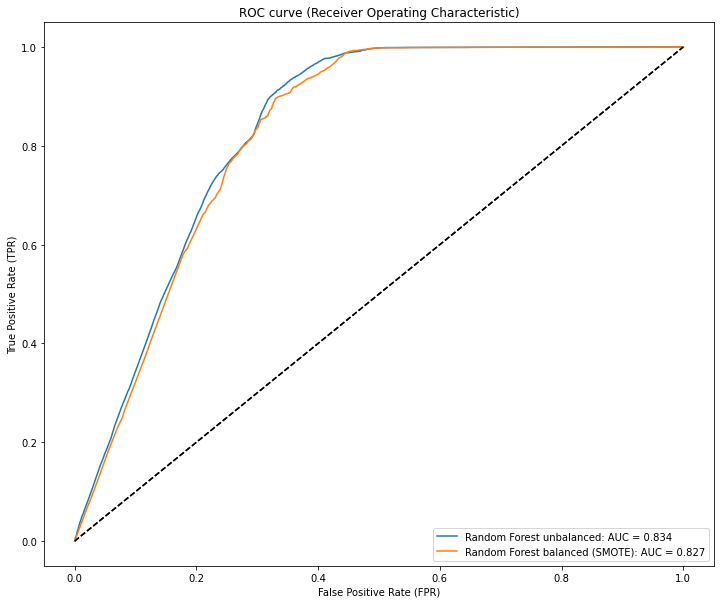

In [39]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test], [y_predProba_rf_imb[:,1], y_predProba_rf_bal[:,1]], ['Random Forest unbalanced', 'Random Forest balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

### Test Logistics Regression when dropping 'Annual Premium' and ' Vintage'

In [46]:
X_sm_new=X_sm.drop(['Annual_Premium','Vintage'],axis=1)

In [47]:
X_test_new=X_test.drop(['Annual_Premium','Vintage'],axis=1)

In [48]:
lr_bal2 = LogisticRegression().fit(X_sm_new, y_sm)

C:\Users\qlam1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
y_pred_lr_bal2 = lr_bal2.predict(X_test_new)
y_predProba_lr_bal2 = lr_bal2.predict_proba(X_test_new)
print ("LR accuracy of new data is:", (accuracy_score(y_test, y_pred_lr_bal2)*100).round(2))

LR accuracy of new data is: 73.34


In [50]:
logit_model=sm.Logit(y_sm,X_sm_new)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.403691
         Iterations 11
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.418      
Dependent Variable:    Response          AIC:               377992.2643
Date:                  2022-02-10 19:42  BIC:               378058.6036
No. Observations:      468156            Log-Likelihood:    -1.8899e+05
Df Model:              5                 LL-Null:           -3.2450e+05
Df Residuals:          468150            LLR p-value:       0.0000     
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        11.0000                                         
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Age                   -0.0159   0.0003  -56.5449 0.0000 -0.016

### Model Evaluation (all models)

#### Accuracy score

In [64]:

model = ['Decision Tree', 'Logistics Regression (Feature Selection)', 'Logistics Regression', 'Random Forest']

score = [(accuracy_score(y_test, y_pred_tree_bal)*100).round(2),(accuracy_score(y_test, y_pred_lr_bal2)*100).round(2),(accuracy_score(y_test, y_pred_lr_bal)*100).round(2),(accuracy_score(y_test, y_pred_rf_bal)*100).round(2)]  


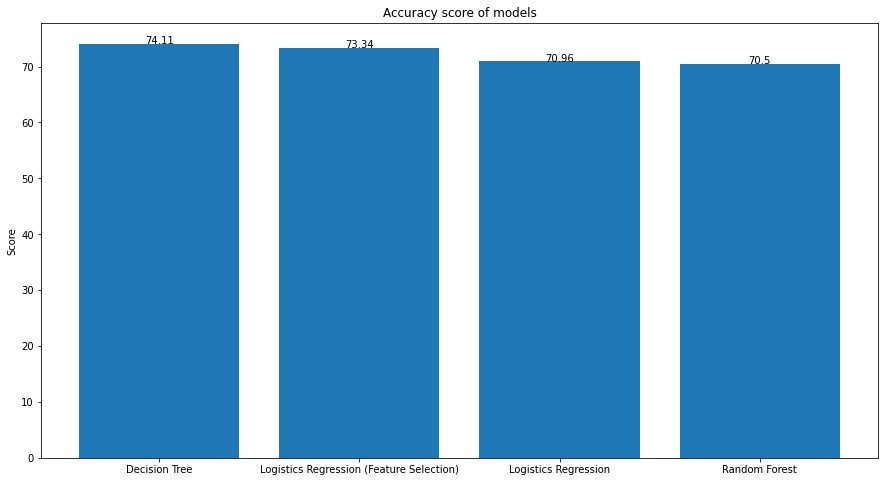

In [66]:
plt.figure(figsize=(15,8)) 
plt.bar(model,score)
plt.title("Accuracy score of models")
plt.ylabel("Score")

for index, value in enumerate(score):
    plt.text(index,value, str(value), ha='center')
plt.show()
    
plt.show()

#### AUC and ROC

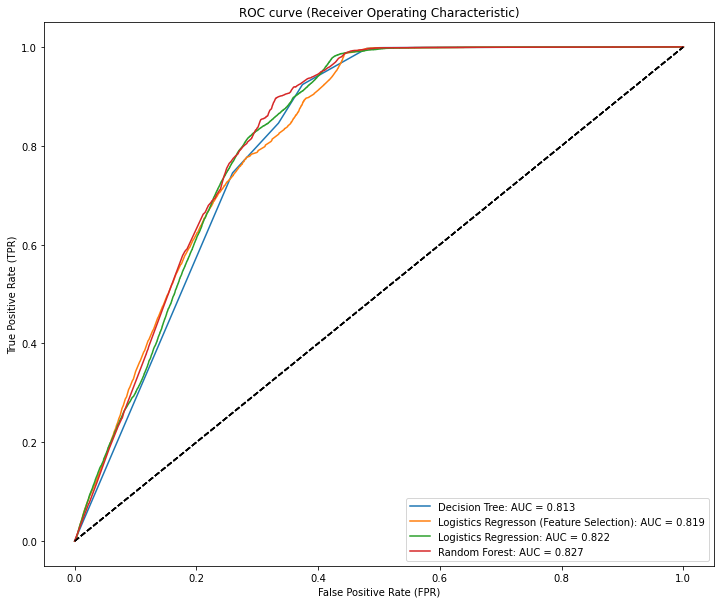

In [61]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test, y_test], [y_predProba_tree_bal[:,1], y_predProba_lr_bal2[:,1] , y_predProba_lr_bal[:,1], y_predProba_rf_bal[:,1]], ['Decision Tree','Logistics Regresson (Feature Selection)', 'Logistics Regression', 'Random Forest']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()